In [5]:
%pip install synthcity

  Using cached synthcity-0.2.10-py3-none-any.whl (428 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.2 MB/s eta 0:00:0000:0100:01
  Using cached nflows-0.14.tar.gz (45 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.2 MB/s eta 0:00:0000:0100:01
  Using cached lifelines-0.27.7-py3-none-any.whl (409 kB)
  Using cached opacus-1.4.1-py3-none-any.whl (226 kB)
  Using cached decaf_synthetic_data-0.1.6-py3-none-any.whl (9.1 kB)
  Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 42.7 MB/s eta 0:00:00
  Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.2 MB/s eta 0:00:0000:0100:01
  Using cached geomloss-0.2.6.tar.gz (

In [1]:
from synthcity.plugins import Plugins
from synthcity.utils.serialization import save_to_file, load_from_file
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import pandas as pd

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [2]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i)
                save_to_file(fp, model)

In [3]:
gen_list = Plugins(categories=["generic"]).list()

[2024-04-12T03:14:46.478527+0000][34347][CRITICAL] module disabled: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [5]:
datasets = {}

In [4]:
ihdp = pd.read_csv('../Datasets/ihdp.csv')

In [5]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [20]:
twins = pd.read_csv('../Datasets/twins.csv')

In [7]:
ihdp

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,False,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,...,1,0,1,0,0,0,0,0,0,0
743,True,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,...,1,1,1,0,0,0,0,0,0,0
744,False,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,...,1,1,1,0,0,0,0,0,0,0
745,False,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,...,1,1,1,0,0,0,0,0,0,0


In [8]:
jobs

,training,age,education,black,hispanic,married,no_degree,re75,re78
0,0.0,19.0,9.0,1.0,0.0,1.0,1.0,0.0000,16658.250
1,0.0,33.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000
2,0.0,25.0,10.0,1.0,0.0,1.0,1.0,0.0000,0.000
3,1.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0000,6551.592
4,0.0,54.0,11.0,1.0,0.0,0.0,1.0,0.0000,7812.522
...,...,...,...,...,...,...,...,...,...
717,1.0,45.0,5.0,1.0,0.0,1.0,1.0,0.0000,8546.715
718,1.0,19.0,10.0,1.0,0.0,0.0,1.0,385.2741,8124.715
719,1.0,26.0,12.0,1.0,0.0,1.0,0.0,5794.8310,1424.944
720,0.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,11197.340


In [21]:
twins

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,...,infant_id,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,35.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,34.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
2,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,...,47.0,NaN,NaN,NaN,5.0,5.0,5.0,737.0,0,0.0
3,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,...,46.0,NaN,NaN,NaN,5.0,5.0,5.0,850.0,1,1.0
4,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,52.0,1.0,1.0,1.0,5.0,5.0,5.0,1830.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23963,1.0,1.0,50.0,55.0,3.0,0.0,1.0,3.0,1.0,50.0,...,278947.0,1.0,2.0,2.0,2.0,2.0,2.0,1758.0,1,0.0
23964,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,5.0,...,278952.0,3.0,3.0,1.0,2.0,2.0,8.0,1616.0,0,0.0
23965,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,5.0,...,278953.0,3.0,3.0,2.0,2.0,2.0,8.0,1814.0,1,0.0
23966,1.0,2.0,51.0,56.0,4.0,0.0,1.0,4.0,1.0,17.0,...,279010.0,1.0,1.0,1.0,7.0,7.0,3.0,936.0,0,1.0


In [29]:
twins_filled = twins.fillna(0)

In [22]:
ctgan = Plugins().get('ctgan')

[2024-04-12T03:18:18.108749+0000][34347][CRITICAL] module disabled: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [11]:
ctgan.fit(jobs)

 15%|█▍        | 299/2000 [00:19<01:49, 15.50it/s]


In [30]:
ctgan.fit(twins_filled)

  0%|          | 3/2000 [00:18<3:30:03,  6.31s/it]


KeyboardInterrupt: 

In [12]:
s = ctgan.generate(count = 722)

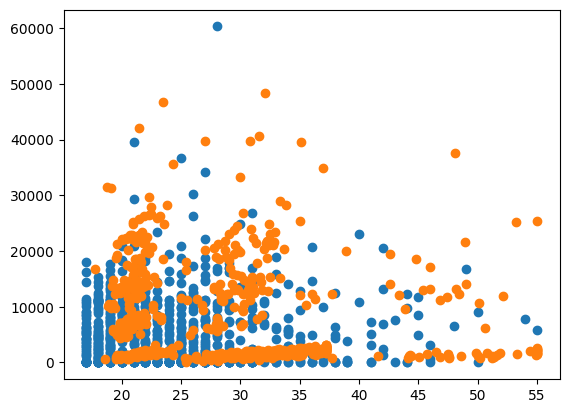

In [13]:
plt.scatter(jobs['age'], jobs['re78'])
plt.scatter(s['age'], s['re78'])

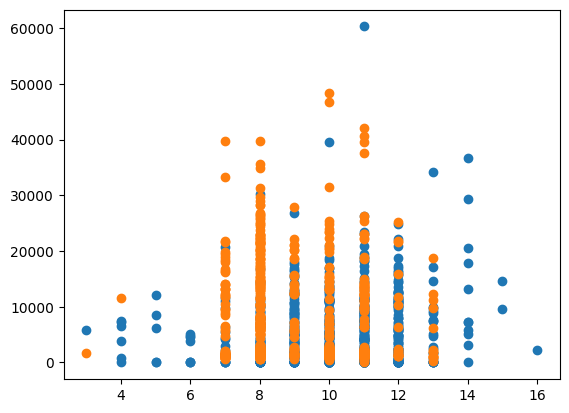

In [14]:
plt.scatter(jobs['education'], jobs['re78'])
plt.scatter(s['education'], s['re78'])

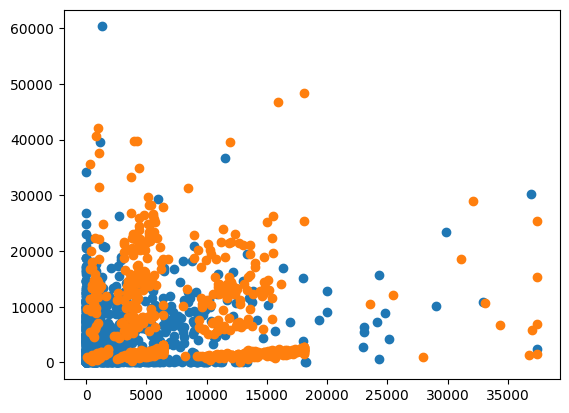

In [15]:
plt.scatter(jobs['re75'], jobs['re78'])
plt.scatter(s['re75'], s['re78'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0c84750130>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0c84750670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0c84713e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0c84750bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0c84750e50>],
 'means': []}

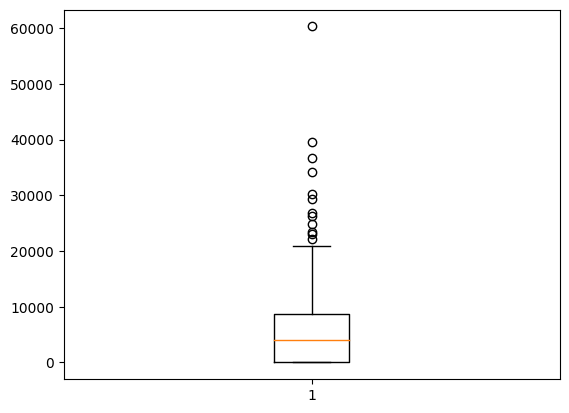

In [16]:
plt.boxplot(jobs['re78'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0c84797640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0c84797b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0c847973a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0c847cc100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0c847cc3a0>],
 'means': []}

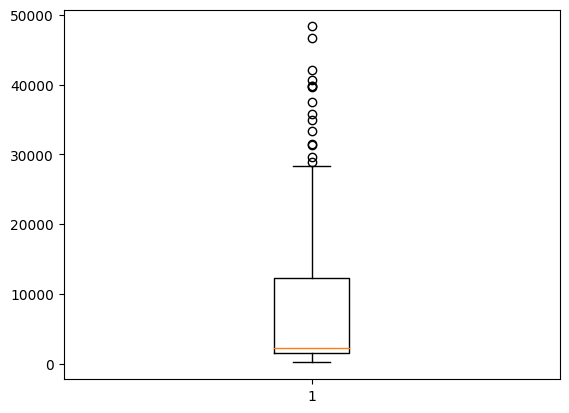

In [17]:
plt.boxplot(s['re78'])

In [18]:
jobs.groupby(['black', 'married', 'no_degree', 'training']).count()

age  education  hispanic  re75  re78
black married no_degree training                                      
0.0   0.0     0.0       0.0        16         16        16    16    16
                        1.0        13         13        13    13    13
              1.0       0.0        57         57        57    57    57
                        1.0        36         36        36    36    36
      1.0     0.0       0.0         2          2         2     2     2
                        1.0         5          5         5     5     5
              1.0       0.0        10         10        10    10    10
                        1.0         5          5         5     5     5
1.0   0.0     0.0       0.0        49         49        49    49    49
                        1.0        54         54        54    54    54
              1.0       0.0       236        236       236   236   236
                        1.0       144        144       144   144   144
      1.0     0.0       0.0        12         12        12    12    12
                        1.0         8          8         8     8     8
              1.0       0.0        43         43        43    43    43
                        1.0        32         32        32    32    32

In [19]:
s.dataframe().groupby(['black', 'married', 'no_degree', 'training']).count()

age  education  hispanic  re75  re78
black married no_degree training                                      
0.0   0.0     0.0       0.0         9          9         9     9     9
                        1.0         2          2         2     2     2
              1.0       0.0        36         36        36    36    36
                        1.0        14         14        14    14    14
      1.0     0.0       0.0         2          2         2     2     2
              1.0       0.0         8          8         8     8     8
                        1.0         6          6         6     6     6
1.0   0.0     0.0       0.0       104        104       104   104   104
                        1.0        31         31        31    31    31
              1.0       0.0       354        354       354   354   354
                        1.0        88         88        88    88    88
      1.0     0.0       0.0        13         13        13    13    13
                        1.0         5          5         5     5     5
              1.0       0.0        36         36        36    36    36
                        1.0        14         14        14    14    14